In [1]:
import os
import glob
import shutil
from functools import partial
from matplotlib.colors import Normalize, CenteredNorm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
#plt.style.use('seaborn-talk') 
plt.style.use('seaborn-v0_8-talk')
import cmocean
import cftime
import datetime
import cartopy.crs as ccrs
import numpy as np
import dask
from dask.distributed import LocalCluster, Client, progress
import netCDF4 as nc
import xarray as xr

In [2]:
# files for medium resolution (0.5 deg atm, 0.1 deg ocn)

# control (RCP8.5, yearly)
cdir = '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f05_t12/rcp8.5_co2_f05_t12/'
camc = cdir+'atm/hist/yearly/rcp8.5_co2_f05_t12.cam2.h0.avg????.nc' # correct time stamps

# spinup (monthly)
sdir = '/projects/0/nwo2021025/cesm1_0_4/outputdata/spinup_pd_maxcores_f05_t12/output/'
cams = cdir+'atm/hist/spinup_pd_maxcores_f05_t12.cam2.h0.????-??.nc' # add 1800 years
ices = cdir+'ice/hist/spinup_pd_maxcores_f05_t12.001.cice.h.????-??.nc'
clms = cdir+'lnd/hist/spinup_pd_maxcores_f05_t12.clm2.h0.????-??.nc'
pops = cdir+'ocn/hist/spinup_pd_maxcores_f05_t12.pop.h.????-??.nc'

# geo (monthly)
gdir = '/projects/0/nwo2021025/archive/mres_b.e10.B2000_CAM5.f05_t12.001/'
camg = gdir+'atm/hist/mres_b.e10.B2000_CAM5.f05_t12.001.cam2.h0.????-??.nc'
iceg = gdir+'ice/hist/mres_b.e10.B2000_CAM5.f05_t12.001.cice.h.????-??.nc'
clmg = gdir+'lnd/hist/mres_b.e10.B2000_CAM5.f05_t12.001.clm2.h0.????-??.nc'
popg = gdir+'ocn/hist/mres_b.e10.B2000_CAM5.f05_t12.001.pop.h.????-??.nc'
aerg = gdir+'strataero/ozone_strataero_1999-2100_SSP585_CAMfeedback.nc'
volg = gdir+'volcaero/volcaero_1999-2100_SSP585_CAMfeedback.nc'

In [3]:
# initiate dask cluster for parallel computing
cluster = LocalCluster(n_workers=2, threads_per_worker=8, memory_limit="14GiB")
client = Client(cluster)
cluster, client

(LocalCluster(d549a2d6, 'tcp://127.0.0.1:37161', workers=2, threads=16, memory=28.00 GiB),
 <Client: 'tcp://127.0.0.1:37161' processes=2 threads=16, memory=28.00 GiB>)

In [4]:
def center_time(ds):
    """set time stamps to center of time_bnds"""
    time = ('time', ds.time_bnds.mean('nbnd').data, ds.time.attrs)
    ds = ds.assign_coords({'ctime':time}).swap_dims({'time':'ctime'})
    return ds.drop_vars('time').rename({'ctime':'time'})


def shift_time(ds, ndays):
    """shift time of dataset by ndays days"""
    dt = datetime.timedelta(days=ndays)
    t0, t1 = ds.time.data[[0,-1]]
    print(f"Shifting time period from {t0}--{t1} to {t0+dt}--{t1+dt}")
    ds = ds.assign(time_bnds=(ds.time_bnds.dims,(ds.time_bnds.compute()+dt).data,ds.time_bnds.attrs))
    return ds.assign(time=(ds.time.dims,(ds.time+dt).data,ds.time.attrs))


def wmean(ds:[xr.Dataset,xr.DataArray], w:xr.DataArray, dims, **kwargs):
    """wrapper for xarray weighted mean
    
    Input:
    ds : data to average
    w : weights
    dims : iterable of dimensions to average over
    kwargs : keyword arguments passed on to .mean(), e.g. keep_attrs
    
    Manual fixes:
        1) only apply averaging along subset of dimensions that is also in 
            dims (returns the unaveraged data if no overlapping dimensions)
        2) always copy coordinate attributes to result
        3) remove weighted operator if w.dims is no subset of ds.dims to 
            prevent broadcasting
        4) let function wmean determine keep_attrs per dataarray instead of 
            map() which applies one value to the whole dataset
    """
    if isinstance(ds, xr.Dataset):
        global WMEAN_ATTRS
        WMEAN_ATTRS = {}
        dsm = ds.map(wmean, False, [w, dims])
        if kwargs.get('keep_attrs', False):
            for v in dsm.data_vars:
                dsm[v].attrs = WMEAN_ATTRS[v] # 4
        return dsm
    if 'WMEAN_ATTRS' in globals():
        WMEAN_ATTRS[ds.name] = ds.attrs
    avgdims = tuple(set(ds.dims).intersection(dims)) # 1
    if len(avgdims)==0: # 1
        return ds
    coordattrs = {c:ds[c].attrs for c in ds.coords}
    if set(w.dims).issubset(ds.dims):
        dsm = ds.weighted(w).mean(avgdims, **kwargs)
    else: # 3
        dsm = ds.mean(avgdims, **kwargs)
    for c in dsm.coords:
        dsm[c].attrs.update(coordattrs[c]) # 2
    return dsm

In [5]:
%%time
cam = {
    # 'cnt': shift_time(center_time(xr.open_mfdataset(camc, data_vars='minimal', coords='minimal', compat='override')), ndays=365*1800),
    'cnt': center_time(xr.open_mfdataset(camc, data_vars='minimal', coords='minimal', compat='override')),
    'geo': center_time(xr.open_mfdataset(camg, data_vars='minimal', coords='minimal', compat='override')),
}

CPU times: user 2min 9s, sys: 6.1 s, total: 2min 15s
Wall time: 3min 47s


In [6]:
%%time
VAR = 'TREFHT'

Y = {
    'geo':(wmean(cam['geo'][VAR], cam['geo'].gw, ('lat','lon'), keep_attrs=True).
           groupby('time.year').mean(keep_attrs=True).compute()),
    'cnt':(wmean(cam['cnt'][VAR], cam['cnt'].gw, ('lat','lon'), keep_attrs=True).
           groupby('time.year').mean(keep_attrs=True).compute()),
}

CPU times: user 8.15 s, sys: 485 ms, total: 8.64 s
Wall time: 1min 9s


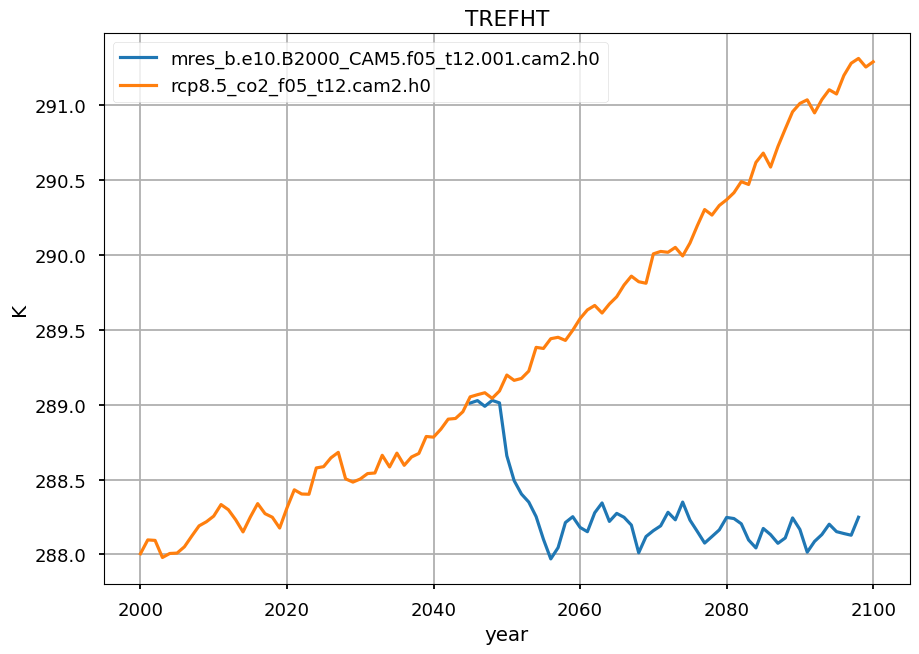

In [7]:
# Plot time series
plt.plot(Y['geo'].year, Y['geo'], label='.'.join(os.path.basename(camg).split('.')[:-2]))
plt.plot(Y['cnt'].year, Y['cnt'], label='.'.join(os.path.basename(camc).split('.')[:-2]))
plt.grid()
plt.title(VAR); plt.ylabel(Y['geo'].units); plt.xlabel('year')
plt.legend()

In [8]:
%%time
VAR = 'TREFHT'
tslice = slice('2070','2098')
Y = {
    'geo':(cam['geo'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True).compute()),
    'cnt':(cam['cnt'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True).compute()),
}
print('geo:',Y['geo'].year.min().data, Y['geo'].year.max().data)
print('cnt:',Y['cnt'].year.min().data, Y['cnt'].year.max().data)

sp = np.sqrt((Y['cnt'].std('year')**2+Y['geo'].std('year'))/2)
t = (Y['cnt'].mean('year') - Y['geo'].mean('year'))/(sp * np.sqrt(2/len(Y['geo'].year)))

geo: 2070 2098
cnt: 2070 2098
CPU times: user 2.38 s, sys: 204 ms, total: 2.59 s
Wall time: 34.8 s


Text(0.5, 0.28, 'geo - cnt')

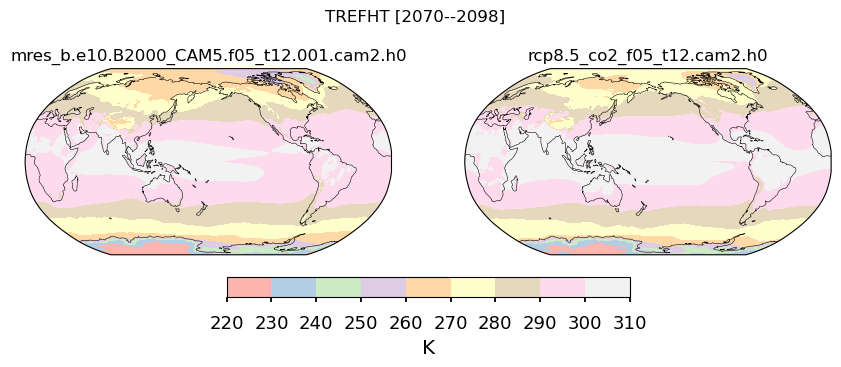

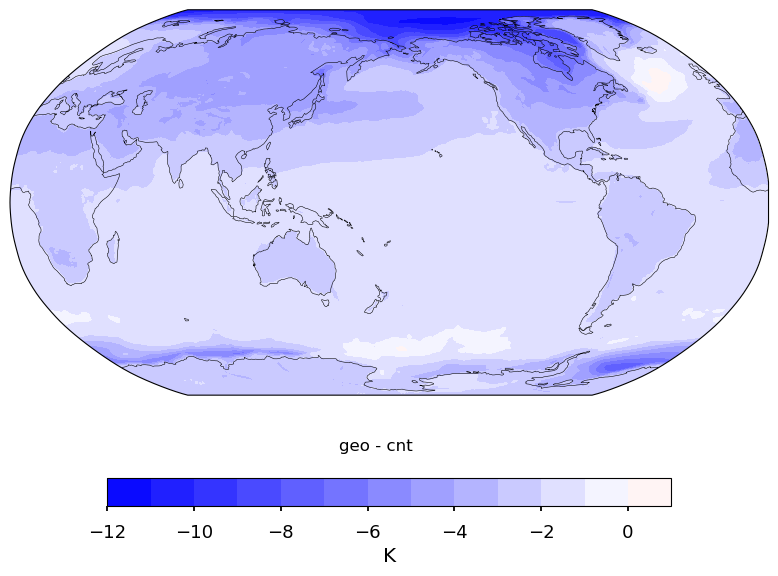

In [11]:
# Plot maps
levels = np.arange(220,311,10)
levels2 = 11#np.linspace(-2.25,2.25,10)
cmap = 'Pastel1'
alpha = 2.776 # t value corresponding to p = 0.05

fig, ax = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
p0 = ax[0].contourf(Y['geo'].lon, Y['geo'].lat, Y['geo'].mean('year'), levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[0].set_title('.'.join(os.path.basename(camg).split('.')[:-2]), fontsize=12)
ax[1].contourf(Y['cnt'].lon, Y['cnt'].lat, Y['cnt'].mean('year'), levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[1].set_title('.'.join(os.path.basename(camc).split('.')[:-2]), fontsize=12)
ax[0].coastlines()
ax[1].coastlines()
fig.colorbar(p0, ax=ax, orientation='horizontal', shrink=.5, pad=.04, label=Y['cnt'].units)
fig.suptitle(f"{VAR} [{tslice.start}--{tslice.stop}]",y=0.6)

fig2 = plt.figure()
ax2 = plt.axes(projection=ax[0].projection)
pd = ax2.contourf(Y['geo'].lon, Y['geo'].lat, (Y['geo']-Y['cnt']).mean('year'), levels=levels2, cmap='bwr', transform=ccrs.PlateCarree(), norm=CenteredNorm())
#cs = ax2.contourf(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=1, colors='k', hatches=['','\\//'], alpha=0, transform=ccrs.PlateCarree())
#ct = ax2.contour(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=[0.5], colors='k', linewidths=.5, transform=ccrs.PlateCarree())
ax2.coastlines()
fig2.colorbar(pd, ax=ax2, orientation='horizontal', shrink=.7, label=Y['geo'].units)
fig2.suptitle('geo - cnt', y=.28)

In [12]:
%%time
VAR = 'PRECT'
tslice = slice('2070','2098')
Y = {
    'geo':(cam['geo'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True).compute()),
    'cnt':(cam['cnt'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True).compute()),
}
print('geo:',Y['geo'].year.min().data, Y['geo'].year.max().data)
print('cnt:',Y['cnt'].year.min().data, Y['cnt'].year.max().data)

sp = np.sqrt((Y['cnt'].std('year')**2+Y['geo'].std('year'))/2)
t = (Y['cnt'].mean('year') - Y['geo'].mean('year'))/(sp * np.sqrt(2/len(Y['geo'].year)))

geo: 2070 2098
cnt: 2070 2098
CPU times: user 2.32 s, sys: 238 ms, total: 2.56 s
Wall time: 32.4 s


Text(0.5, 0.28, 'geo - cnt')

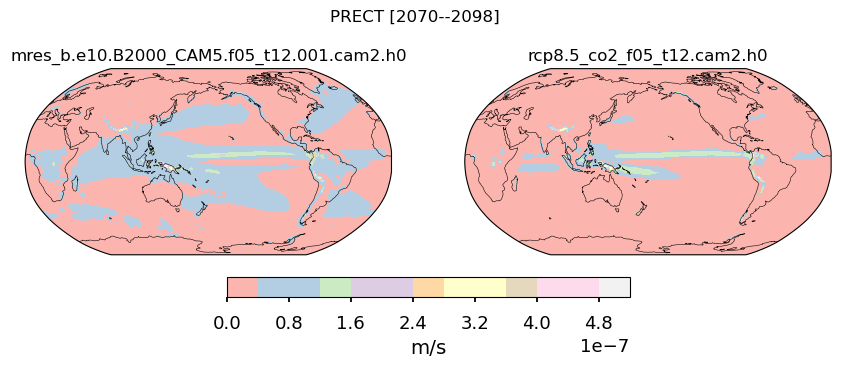

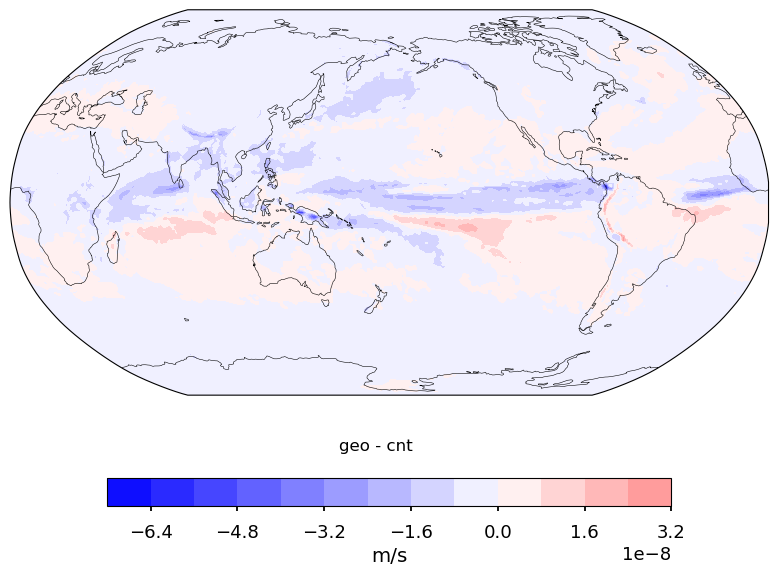

In [14]:
# Plot maps
levels = 15#np.arange(220,311,10)
levels2 = 11#np.linspace(-2.25,2.25,10)
cmap = 'Pastel1'
alpha = 2.776 # t value corresponding to p = 0.05

fig, ax = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
p0 = ax[0].contourf(Y['geo'].lon, Y['geo'].lat, Y['geo'].mean('year'), levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[0].set_title('.'.join(os.path.basename(camg).split('.')[:-2]), fontsize=12)
ax[1].contourf(Y['cnt'].lon, Y['cnt'].lat, Y['cnt'].mean('year'), levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[1].set_title('.'.join(os.path.basename(camc).split('.')[:-2]), fontsize=12)
ax[0].coastlines()
ax[1].coastlines()
fig.colorbar(p0, ax=ax, orientation='horizontal', shrink=.5, pad=.04, label=Y['cnt'].units)
fig.suptitle(f"{VAR} [{tslice.start}--{tslice.stop}]",y=0.6)

fig2 = plt.figure()
ax2 = plt.axes(projection=ax[0].projection)
pd = ax2.contourf(Y['geo'].lon, Y['geo'].lat, (Y['geo']-Y['cnt']).mean('year'), levels=levels2, cmap='bwr', transform=ccrs.PlateCarree(), norm=CenteredNorm())
#cs = ax2.contourf(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=1, colors='k', hatches=['','\\//'], alpha=0, transform=ccrs.PlateCarree())
#ct = ax2.contour(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=[0.5], colors='k', linewidths=.5, transform=ccrs.PlateCarree())
ax2.coastlines()
fig2.colorbar(pd, ax=ax2, orientation='horizontal', shrink=.7, label=Y['geo'].units)
fig2.suptitle('geo - cnt', y=.28)

In [17]:
%%time
VAR = 'CLDTOT'
tslice = slice('2070','2098')
Y = {
    'geo':(cam['geo'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True).compute()),
    'cnt':(cam['cnt'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True).compute()),
}
print('geo:',Y['geo'].year.min().data, Y['geo'].year.max().data)
print('cnt:',Y['cnt'].year.min().data, Y['cnt'].year.max().data)

sp = np.sqrt((Y['cnt'].std('year')**2+Y['geo'].std('year'))/2)
t = (Y['cnt'].mean('year') - Y['geo'].mean('year'))/(sp * np.sqrt(2/len(Y['geo'].year)))

geo: 2070 2098
cnt: 2070 2098
CPU times: user 2.51 s, sys: 228 ms, total: 2.73 s
Wall time: 35.6 s


Text(0.5, 0.28, 'geo - cnt')

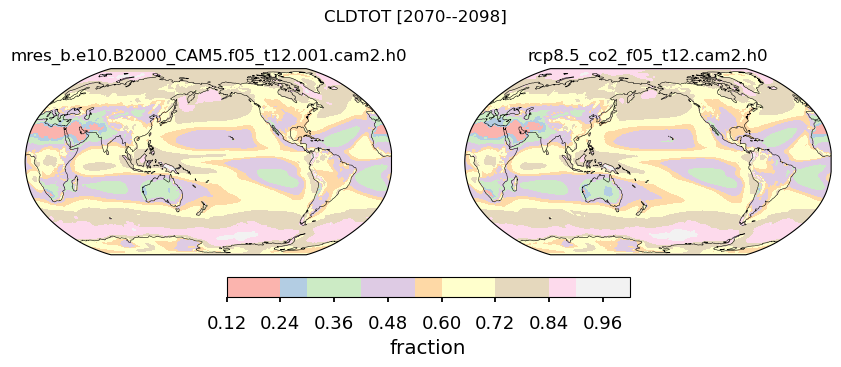

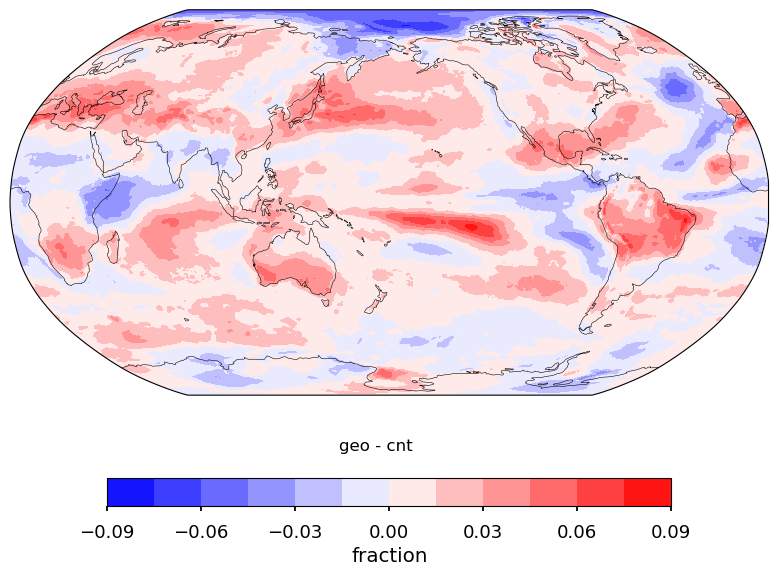

In [18]:
# Plot maps
levels = 15#np.arange(220,311,10)
levels2 = 11#np.linspace(-2.25,2.25,10)
cmap = 'Pastel1'
alpha = 2.776 # t value corresponding to p = 0.05

fig, ax = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
p0 = ax[0].contourf(Y['geo'].lon, Y['geo'].lat, Y['geo'].mean('year'), levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[0].set_title('.'.join(os.path.basename(camg).split('.')[:-2]), fontsize=12)
ax[1].contourf(Y['cnt'].lon, Y['cnt'].lat, Y['cnt'].mean('year'), levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[1].set_title('.'.join(os.path.basename(camc).split('.')[:-2]), fontsize=12)
ax[0].coastlines()
ax[1].coastlines()
fig.colorbar(p0, ax=ax, orientation='horizontal', shrink=.5, pad=.04, label=Y['cnt'].units)
fig.suptitle(f"{VAR} [{tslice.start}--{tslice.stop}]",y=0.6)

fig2 = plt.figure()
ax2 = plt.axes(projection=ax[0].projection)
pd = ax2.contourf(Y['geo'].lon, Y['geo'].lat, (Y['geo']-Y['cnt']).mean('year'), levels=levels2, cmap='bwr', transform=ccrs.PlateCarree(), norm=CenteredNorm())
#cs = ax2.contourf(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=1, colors='k', hatches=['','\\//'], alpha=0, transform=ccrs.PlateCarree())
#ct = ax2.contour(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=[0.5], colors='k', linewidths=.5, transform=ccrs.PlateCarree())
ax2.coastlines()
fig2.colorbar(pd, ax=ax2, orientation='horizontal', shrink=.7, label=Y['geo'].units)
fig2.suptitle('geo - cnt', y=.28)

In [19]:
%%time
VAR = 'PSL'
tslice = slice('2070','2098')
Y = {
    'geo':(cam['geo'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True).compute()),
    'cnt':(cam['cnt'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True).compute()),
}
print('geo:',Y['geo'].year.min().data, Y['geo'].year.max().data)
print('cnt:',Y['cnt'].year.min().data, Y['cnt'].year.max().data)

sp = np.sqrt((Y['cnt'].std('year')**2+Y['geo'].std('year'))/2)
t = (Y['cnt'].mean('year') - Y['geo'].mean('year'))/(sp * np.sqrt(2/len(Y['geo'].year)))

geo: 2070 2098
cnt: 2070 2098
CPU times: user 2.51 s, sys: 202 ms, total: 2.71 s
Wall time: 31.4 s


Text(0.5, 0.28, 'geo - cnt')

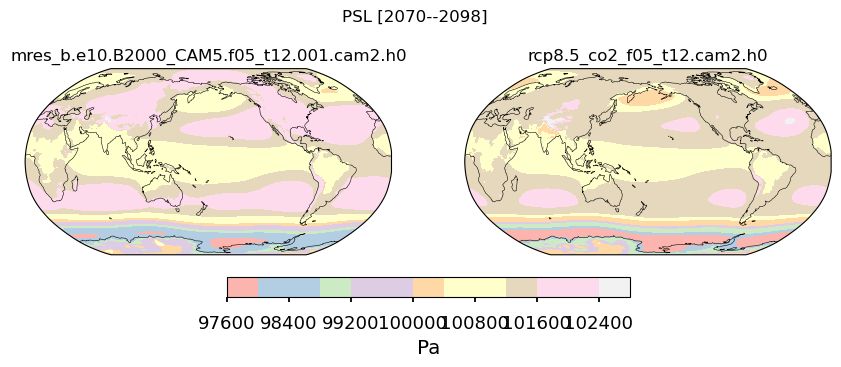

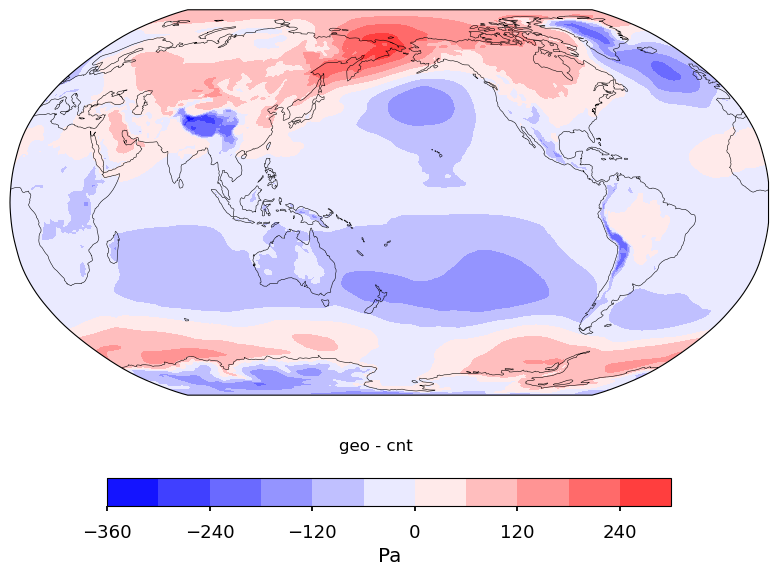

In [20]:
# Plot maps
levels = 15#np.arange(220,311,10)
levels2 = 11#np.linspace(-2.25,2.25,10)
cmap = 'Pastel1'
alpha = 2.776 # t value corresponding to p = 0.05

fig, ax = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
p0 = ax[0].contourf(Y['geo'].lon, Y['geo'].lat, Y['geo'].mean('year'), levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[0].set_title('.'.join(os.path.basename(camg).split('.')[:-2]), fontsize=12)
ax[1].contourf(Y['cnt'].lon, Y['cnt'].lat, Y['cnt'].mean('year'), levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[1].set_title('.'.join(os.path.basename(camc).split('.')[:-2]), fontsize=12)
ax[0].coastlines()
ax[1].coastlines()
fig.colorbar(p0, ax=ax, orientation='horizontal', shrink=.5, pad=.04, label=Y['cnt'].units)
fig.suptitle(f"{VAR} [{tslice.start}--{tslice.stop}]",y=0.6)

fig2 = plt.figure()
ax2 = plt.axes(projection=ax[0].projection)
pd = ax2.contourf(Y['geo'].lon, Y['geo'].lat, (Y['geo']-Y['cnt']).mean('year'), levels=levels2, cmap='bwr', transform=ccrs.PlateCarree(), norm=CenteredNorm())
#cs = ax2.contourf(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=1, colors='k', hatches=['','\\//'], alpha=0, transform=ccrs.PlateCarree())
#ct = ax2.contour(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=[0.5], colors='k', linewidths=.5, transform=ccrs.PlateCarree())
ax2.coastlines()
fig2.colorbar(pd, ax=ax2, orientation='horizontal', shrink=.7, label=Y['geo'].units)
fig2.suptitle('geo - cnt', y=.28)

In [24]:
%%time
VAR = 'U'
tslice = slice('2070','2098')

Y = {
    'geo':abs(cam['geo'][VAR].interp(lev=850,method='nearest')-cam['geo'][VAR].interp(lev=250,method='nearest')).sel(time=tslice).groupby('time.year').mean(keep_attrs=True).compute(),
    'cnt':abs(cam['cnt'][VAR].interp(lev=850,method='nearest')-cam['cnt'][VAR].interp(lev=250,method='nearest')).sel(time=tslice).groupby('time.year').mean(keep_attrs=True).compute(),
}
print('geo:',Y['geo'].year.min().data, Y['geo'].year.max().data)
print('cnt:',Y['cnt'].year.min().data, Y['cnt'].year.max().data)

sp = np.sqrt((Y['cnt'].std('year')**2+Y['geo'].std('year'))/2)
t = (Y['cnt'].mean('year') - Y['geo'].mean('year'))/(sp * np.sqrt(2/len(Y['geo'].year)))

geo: 2070 2098
cnt: 2070 2098
CPU times: user 3.94 s, sys: 344 ms, total: 4.28 s
Wall time: 51.1 s


Text(0.5, 0.28, 'geo - cnt')

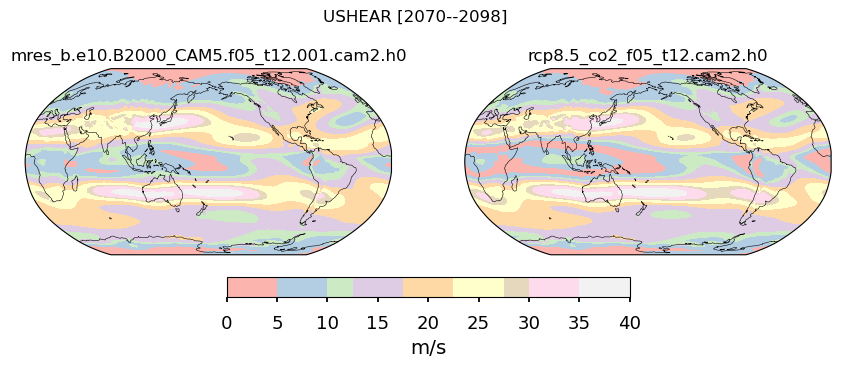

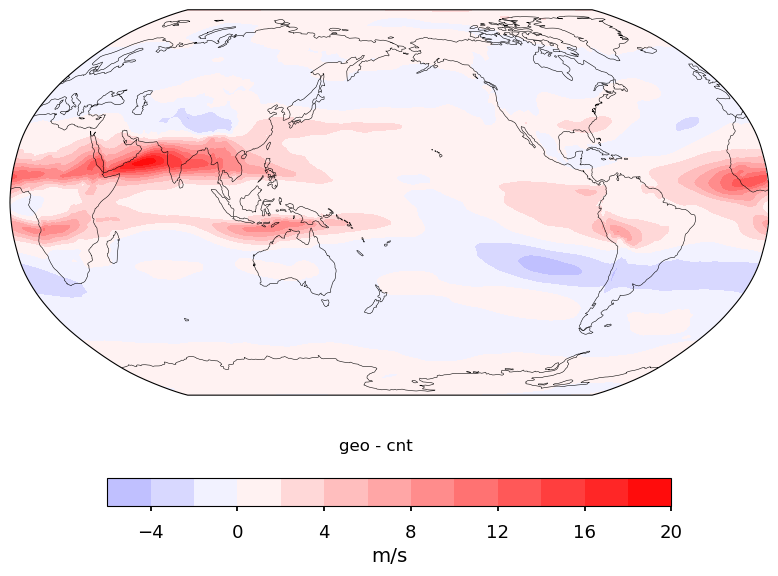

In [27]:
# Plot maps
levels = 15#np.arange(220,311,10)
levels2 = 11#np.linspace(-2.25,2.25,10)
cmap = 'Pastel1'
alpha = 2.776 # t value corresponding to p = 0.05

fig, ax = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
p0 = ax[0].contourf(Y['geo'].lon, Y['geo'].lat, Y['geo'].mean('year'), levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[0].set_title('.'.join(os.path.basename(camg).split('.')[:-2]), fontsize=12)
ax[1].contourf(Y['cnt'].lon, Y['cnt'].lat, Y['cnt'].mean('year'), levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[1].set_title('.'.join(os.path.basename(camc).split('.')[:-2]), fontsize=12)
ax[0].coastlines()
ax[1].coastlines()
fig.colorbar(p0, ax=ax, orientation='horizontal', shrink=.5, pad=.04, label='m/s')
fig.suptitle(f"USHEAR [{tslice.start}--{tslice.stop}]",y=0.6)

fig2 = plt.figure()
ax2 = plt.axes(projection=ax[0].projection)
pd = ax2.contourf(Y['geo'].lon, Y['geo'].lat, (Y['geo']-Y['cnt']).mean('year'), levels=levels2, cmap='bwr', transform=ccrs.PlateCarree(), norm=CenteredNorm())
#cs = ax2.contourf(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=1, colors='k', hatches=['','\\//'], alpha=0, transform=ccrs.PlateCarree())
#ct = ax2.contour(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=[0.5], colors='k', linewidths=.5, transform=ccrs.PlateCarree())
ax2.coastlines()
fig2.colorbar(pd, ax=ax2, orientation='horizontal', shrink=.7, label='m/s')
fig2.suptitle('geo - cnt', y=.28)

In [29]:
%%time
VAR = 'T'
tslice = slice('2070','2098')
Y = {
    'geo':(cam['geo'][VAR].interp(lev=250,method='nearest').sel(time=tslice).groupby('time.year').mean(keep_attrs=True).compute()),
    'cnt':(cam['cnt'][VAR].interp(lev=250,method='nearest').sel(time=tslice).groupby('time.year').mean(keep_attrs=True).compute()),
}
print('geo:',Y['geo'].year.min().data, Y['geo'].year.max().data)
print('cnt:',Y['cnt'].year.min().data, Y['cnt'].year.max().data)

sp = np.sqrt((Y['cnt'].std('year')**2+Y['geo'].std('year'))/2)
t = (Y['cnt'].mean('year') - Y['geo'].mean('year'))/(sp * np.sqrt(2/len(Y['geo'].year)))

geo: 2070 2098
cnt: 2070 2098
CPU times: user 3.03 s, sys: 300 ms, total: 3.33 s
Wall time: 44.7 s


Text(0.5, 0.28, 'geo - cnt')

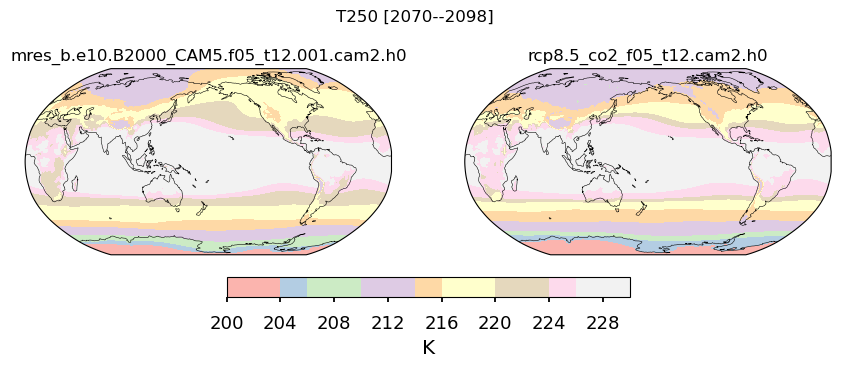

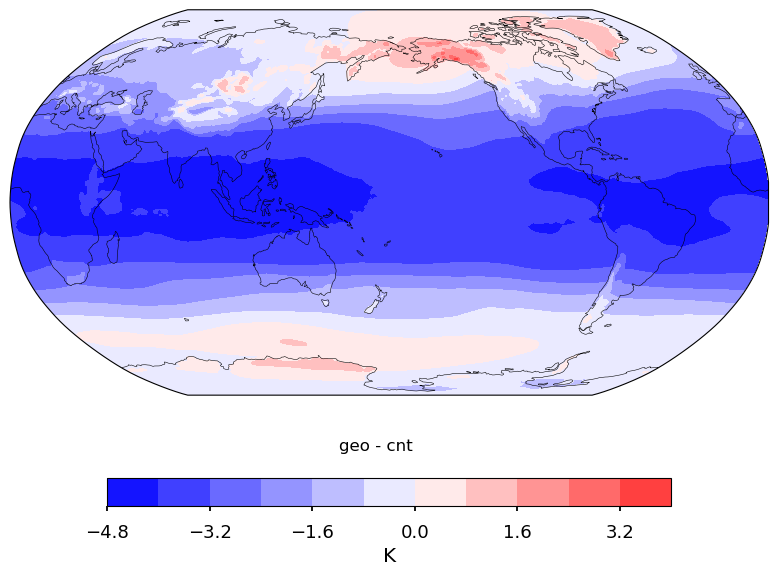

In [30]:
# Plot maps
levels = 15#np.arange(220,311,10)
levels2 = 11#np.linspace(-2.25,2.25,10)
cmap = 'Pastel1'
alpha = 2.776 # t value corresponding to p = 0.05

fig, ax = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
p0 = ax[0].contourf(Y['geo'].lon, Y['geo'].lat, Y['geo'].mean('year'), levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[0].set_title('.'.join(os.path.basename(camg).split('.')[:-2]), fontsize=12)
ax[1].contourf(Y['cnt'].lon, Y['cnt'].lat, Y['cnt'].mean('year'), levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[1].set_title('.'.join(os.path.basename(camc).split('.')[:-2]), fontsize=12)
ax[0].coastlines()
ax[1].coastlines()
fig.colorbar(p0, ax=ax, orientation='horizontal', shrink=.5, pad=.04, label='K')
fig.suptitle(f"T250 [{tslice.start}--{tslice.stop}]",y=0.6)

fig2 = plt.figure()
ax2 = plt.axes(projection=ax[0].projection)
pd = ax2.contourf(Y['geo'].lon, Y['geo'].lat, (Y['geo']-Y['cnt']).mean('year'), levels=levels2, cmap='bwr', transform=ccrs.PlateCarree(), norm=CenteredNorm())
#cs = ax2.contourf(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=1, colors='k', hatches=['','\\//'], alpha=0, transform=ccrs.PlateCarree())
#ct = ax2.contour(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=[0.5], colors='k', linewidths=.5, transform=ccrs.PlateCarree())
ax2.coastlines()
fig2.colorbar(pd, ax=ax2, orientation='horizontal', shrink=.7, label='K')
fig2.suptitle('geo - cnt', y=.28)

In [32]:
%%time
VAR = 'Q'
tslice = slice('2070','2098')
Y = {
    'geo':(cam['geo'][VAR].interp(lev=500,method='nearest').sel(time=tslice).groupby('time.year').mean(keep_attrs=True).compute()),
    'cnt':(cam['cnt'][VAR].interp(lev=500,method='nearest').sel(time=tslice).groupby('time.year').mean(keep_attrs=True).compute()),
}
print('geo:',Y['geo'].year.min().data, Y['geo'].year.max().data)
print('cnt:',Y['cnt'].year.min().data, Y['cnt'].year.max().data)

sp = np.sqrt((Y['cnt'].std('year')**2+Y['geo'].std('year'))/2)
t = (Y['cnt'].mean('year') - Y['geo'].mean('year'))/(sp * np.sqrt(2/len(Y['geo'].year)))

geo: 2070 2098
cnt: 2070 2098
CPU times: user 4.84 s, sys: 269 ms, total: 5.11 s
Wall time: 44.2 s


Text(0.5, 0.28, 'geo - cnt')

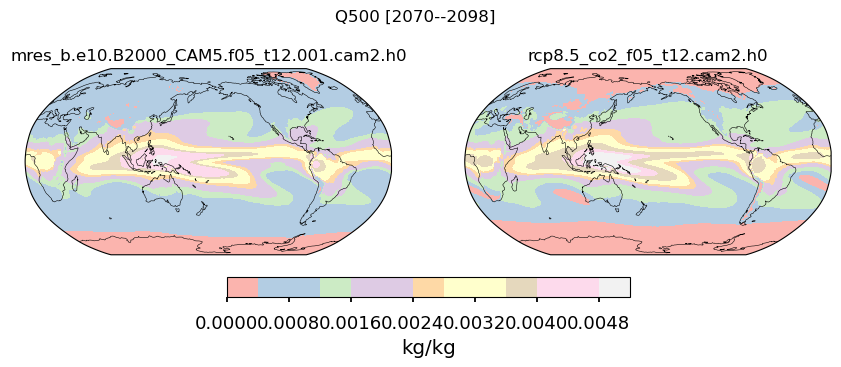

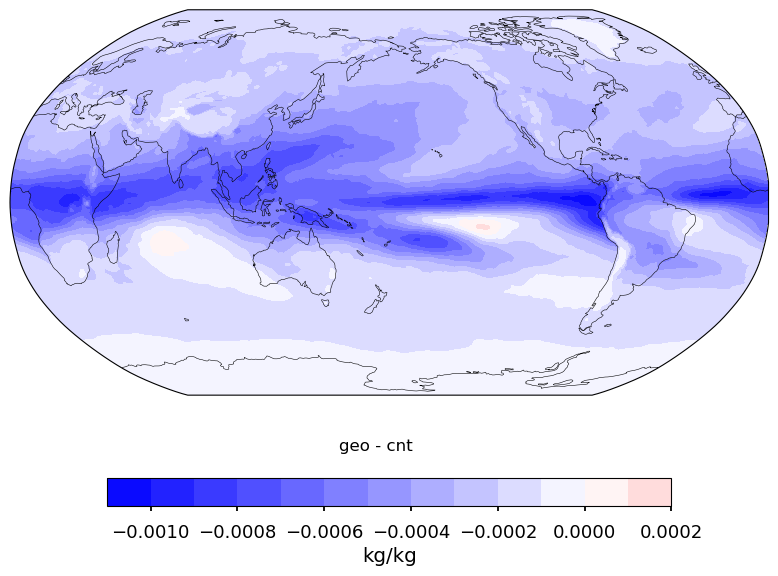

In [33]:
# Plot maps
levels = 15#np.arange(220,311,10)
levels2 = 11#np.linspace(-2.25,2.25,10)
cmap = 'Pastel1'
alpha = 2.776 # t value corresponding to p = 0.05

fig, ax = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
p0 = ax[0].contourf(Y['geo'].lon, Y['geo'].lat, Y['geo'].mean('year'), levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[0].set_title('.'.join(os.path.basename(camg).split('.')[:-2]), fontsize=12)
ax[1].contourf(Y['cnt'].lon, Y['cnt'].lat, Y['cnt'].mean('year'), levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[1].set_title('.'.join(os.path.basename(camc).split('.')[:-2]), fontsize=12)
ax[0].coastlines()
ax[1].coastlines()
fig.colorbar(p0, ax=ax, orientation='horizontal', shrink=.5, pad=.04, label='kg/kg')
fig.suptitle(f"Q500 [{tslice.start}--{tslice.stop}]",y=0.6)

fig2 = plt.figure()
ax2 = plt.axes(projection=ax[0].projection)
pd = ax2.contourf(Y['geo'].lon, Y['geo'].lat, (Y['geo']-Y['cnt']).mean('year'), levels=levels2, cmap='bwr', transform=ccrs.PlateCarree(), norm=CenteredNorm())
#cs = ax2.contourf(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=1, colors='k', hatches=['','\\//'], alpha=0, transform=ccrs.PlateCarree())
#ct = ax2.contour(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=[0.5], colors='k', linewidths=.5, transform=ccrs.PlateCarree())
ax2.coastlines()
fig2.colorbar(pd, ax=ax2, orientation='horizontal', shrink=.7, label='kg/kg')
fig2.suptitle('geo - cnt', y=.28)